In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
## This is a notebook for running the model that predicts ED and MCES20
## Big difference with previous models: We can't use cosine similarity to compute analog discovery
## I have to:
## 1) copy the mces20-ed model from vsc to local folder
## 2) Replace the computation of the cosine similary by the computation of the fully connected layer

In [7]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [8]:
from src.transformers.sklearn_model import SklearnModel
import gensim
from src.load_data import LoadData
from src.config import Config
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from src.molecule_pairs_opt import MoleculePairsOpt
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr
from src.transformers.embedder import Embedder
from src.transformers.encoder import Encoder
import matplotlib.pyplot as plt
from src.transformers.CustomDatasetEncoder import CustomDatasetEncoder
from src.transformers.load_data_encoder import LoadDataEncoder
from src.transformers.load_data_unique import LoadDataUnique
from torch.utils.data import DataLoader
from src.analog_discovery.cosine_similarity import CosineSimilarity
from rdkit import Chem
from src.analog_discovery.analog_discovery import AnalogDiscovery
from src.analog_discovery.mces import MCES
from src.analog_discovery.ad_multitask import ADMultitask
from src.analog_discovery.fc_layers_analog_discovery import FcLayerAnalogDiscovery
import copy
from src.ordinal_classification.embedder_multitask import EmbedderMultitask
from src.plotting import Plotting

## params

In [9]:
MULTITASKING=True

In [10]:
data_folder= '/Users/sebas/projects/data/'
janssen_path = data_folder + 'drug_plus.mgf'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
#dataset_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'
#dataset_path= data_folder +'merged_gnps_nist_20240319_unique_smiles_1_million_v2_no_identity.pkl'
dataset_path= data_folder +'edit_distance_neurips_nist_exhaustive.pkl'

#model_path = data_folder + 'best_model_mces20_ed_optimized_20241017.ckpt'  ##### UNTIL NOW THE BEST RESULTS
#model_path = data_folder + 'best_model_mces20_ed_20241118_precursor_augmentation_false_mz.ckpt'
#model_path = data_folder + 'best_model_mces20_ed_20241120_contrastive.ckpt'
#model_path = data_folder + 'best_model_mces20_ed_maxp20.ckpt'
#model_path = data_folder + 'best_model_mces20_ed_maxp40.ckpt'
#model_path = data_folder + 'best_model_mces20_ed_nofilteredpeaks.ckpt'
#model_path = data_folder + 'best_model_mces20_ed_augmentations.ckpt'  ## BEST RESULTS UNTIL NOW
#model_path = data_folder + 'best_model_generated_data_20250126.ckpt'  ## BEST RESULTS UNTIL NOW
model_path = data_folder + 'best_model_generated_data_20250130.ckpt'  ## BEST RESULTS UNTIL NOW
#model_path = data_folder + 'best_model_mces20_ed_augmentations_nosim1.ckpt'  ## BEST RESULTS UNTIL NOW

#model_path = data_folder + 'best_model_mces20_ed_20241024_pretraining.ckpt'
casmi_file= data_folder + 'processed_massformer/spec_df.pkl' 

In [11]:
config=Config()

In [12]:
config.D_MODEL=256
#config.D_MODEL=512
config.N_LAYERS=5
config.TRANSFORMER_CONTEXT=100

In [13]:
#if model_path.endswith('best_model_mces20_ed_optimized_20241017.ckpt'):
config.use_cosine_distance=True
#else:
#    config.use_cosine_distance=False

In [14]:
model_path

'/Users/sebas/projects/data/best_model_generated_data_20250130.ckpt'

In [15]:
config.use_cosine_distance

True

In [16]:
USE_CASMI=True
USE_MCES_RAW=False

In [17]:
#similarity_name= 'simba_EDIT_DISTANCE_WITH_CONFIDENCE'
#similarity_name= 'simba_EDIT_DISTANCE'
#similarity_name= 'simba_EDIT_DISTANCE_MCES20_NEURIPS_precursor_randomized'
similarity_name= 'simba_generated_data_20250130'
#similarity_name= 'simba_EDIT_DISTANCE_MCES20_NEURIPS_2METRICS'
#similarity_name= 'simba_EDIT_DISTANCE_PRETRAINING_WITHOUT_CONFIDENCE'

In [18]:
USE_MS2DEEPSCORE =False
if USE_MS2DEEPSCORE:
    similarity_name= 'simba_SIMBA_ENSEMBLED_MS2DEEPSCORE_SPEC2VEC'

In [19]:
data_folder= '/Users/sebas/projects/data/'
model_ms2d_file = data_folder + 'ms2deepscore_positive_10k_1000_1000_1000_500.hdf5'
model_spec2vec_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'

In [20]:
from ms2deepscore import MS2DeepScore
from ms2deepscore.models import load_model
import tensorflow as tf
from matchms import calculate_scores
from src.matchms_utils import MatchmsUtils
from spec2vec import Spec2Vec

class Ms2wrapper:
    def __init__(self, model_ms2d_file):
        self.model_ms2d = load_model(model_ms2d_file)
        self.similarity_model= MS2DeepScore(self.model_ms2d)
        
    def get_predictions_ms2deepscore(self,s1, s2):
        results_ms2_all=[]
        s_query= MatchmsUtils.from_su_to_matchms(s1)
        s_ref= MatchmsUtils.from_su_to_matchms(s2)
        with tf.device('/device:CPU:0'): #execute on cpu
                results_ms2 = calculate_scores([s_query], [s_ref], self.similarity_model)
        return results_ms2.to_array()

    def compute_similarity_matrix(self,specs_su_1, specs_su_2):
        results_ms2_all=[]
        s_query= [MatchmsUtils.from_su_to_matchms(s1) for s1 in specs_su_1]
        s_ref=  [MatchmsUtils.from_su_to_matchms(s2) for s2 in specs_su_2]
        with tf.device('/device:CPU:0'): #execute on cpu
                results_ms2 = calculate_scores(s_query, s_ref, self.similarity_model)
        return results_ms2.to_array()

class Spec2vec_wrapper:
    def __init__(self, model_ms2d_file):
        self.model = gensim.models.Word2Vec.load(model_spec2vec_file)
        self.similarity_model= Spec2Vec(
                model=self.model, intensity_weighting_power=0.5, allowed_missing_percentage=100.0
            )
    def compute_similarity_matrix(self,specs_su_1, specs_su_2):
        s_query= [MatchmsUtils.from_su_to_matchms(s1) for s1 in specs_su_1]
        s_ref=  [MatchmsUtils.from_su_to_matchms(s2) for s2 in specs_su_2]
        with tf.device('/device:CPU:0'): #execute on cpu
                results_spec2vec_all = calculate_scores(s_query, s_ref, self.similarity_model)
        return results_spec2vec_all.to_array()

In [21]:
#ms2_object=Spec2vec_wrapper(model_spec2vec_file)
#ms2_object=Ms2wrapper(model_ms2d_file)

In [22]:
def get_similarities_combined(sim1, sim2_softmax, threshold_ed5=0.9):
    '''
    return a similarity proxy based on sim1 and sim2
    '''
    #return sim1*(sim2>0)
    probability_ed5= sim2_softmax[:,:,0]
    return sim1*(~((probability_ed5>threshold_ed5)  & (sim1>0.50))  ) ## remove bad predictions

## open janssen data

In [23]:
if USE_CASMI:
    all_spectrums_janssen_original=LoadData.get_all_spectrums_casmi(
        casmi_file,
        config=config,
    )
else:
    loader_saver = LoaderSaver(
            block_size=100,
            pickle_nist_path='',
            pickle_gnps_path='',
            pickle_janssen_path=output_janssen_file,
        )
    all_spectrums_janssen_original = loader_saver.get_all_spectrums(
                janssen_path,
                100000000,
                use_tqdm=True,
                use_nist=False,
                config=config,
                use_janssen=True,
            )

In [24]:
ls projects/data/processed_massformer

ls: projects/data/processed_massformer: No such file or directory


In [25]:
all_spectrums_janssen_processed= [copy.deepcopy(s) for s in all_spectrums_janssen_original]
pp=Preprocessor()
### remove extra peaks in janssen
all_spectrums_janssen_processed = [pp.preprocess_spectrum(
            s,
            fragment_tol_mass=10,
            fragment_tol_mode="ppm",
            min_intensity=0.01,
            max_num_peaks=1000,
            scale_intensity=None,
        ) for s in all_spectrums_janssen_processed]


all_spectrums_janssen = [s_original for s_original, s_processed in zip(all_spectrums_janssen_original,all_spectrums_janssen_processed) if len(s_processed.mz)>=6]

## Filter only one spectra?

## open ref data

In [26]:
with open(dataset_path, 'rb') as file:
            dataset = dill.load(file)

In [27]:
dataset['molecule_pairs_test']

In [28]:
all_spectrums_reference_original= dataset['molecule_pairs_train'].spectrums_original +\
                    dataset['molecule_pairs_val'].spectrums_original + \
                        dataset['molecule_pairs_test'].spectrums_original


In [29]:
import copy


In [30]:
all_spectrums_reference_processed= [copy.deepcopy(s) for s in all_spectrums_reference_original]
all_spectrums_reference_processed = [pp.preprocess_spectrum(
            s,
            fragment_tol_mass=10,
            fragment_tol_mode="ppm",
            min_intensity=0.01,
            max_num_peaks=1000,
            scale_intensity='root',
        ) for s in all_spectrums_reference_processed]
    
all_spectrums_reference = [s_original for s_original, s_processed in zip(all_spectrums_reference_original,all_spectrums_reference_processed) if len(s_processed.mz)>=6]

In [31]:
## extra filtering to discard bad spectra in the reference dataset
all_spectrums_reference_processed_2= [copy.deepcopy(s) for s in all_spectrums_reference_original]
all_spectrums_reference_processed_2 = [pp.preprocess_spectrum(
            s,
            fragment_tol_mass=10,
            fragment_tol_mode="ppm",
            min_intensity=0.1,
            max_num_peaks=100,
            scale_intensity=None,
        ) for s in all_spectrums_reference_processed_2]
    
more_informative_spectrums = [1 if len(s.mz)>2 else 0 for s in all_spectrums_reference_processed_2]

## histogram of peaks

In [32]:
len_z_ref= np.array([len(s.mz) for s in all_spectrums_reference_processed])


In [33]:
len(len_z_ref)

328555

In [34]:
min(len_z_ref)

7

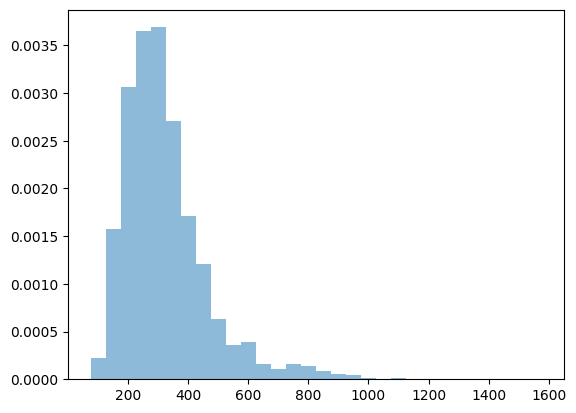

In [35]:
mz_ref= np.array([s.precursor_mz for s in all_spectrums_reference_processed] , )
_=plt.hist(mz_ref[np.random.randint(0,len(mz_ref), 10000)], bins=30, alpha=0.5,label='ref' , density=True)

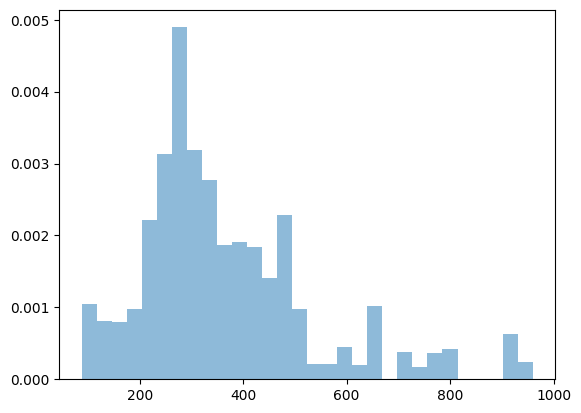

In [36]:
mz_ref= np.array([s.precursor_mz for s in all_spectrums_janssen_processed] , )
_=plt.hist(mz_ref[np.random.randint(0,len(mz_ref), 10000)], bins=30, alpha=0.5,label='ref' , density=True)


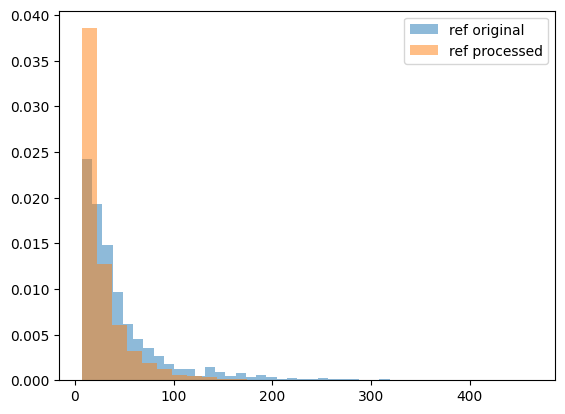

In [37]:
len_z_ref= np.array([len(s.mz) for s in all_spectrums_reference] , )
_=plt.hist(len_z_ref[np.random.randint(0,len(len_z_ref), 1000)], bins=30, alpha=0.5, label='ref original', density=True)
len_z_ref= np.array([len(s.mz) for s in all_spectrums_reference_processed], )
_=plt.hist(len_z_ref[np.random.randint(0,len(len_z_ref), 10000)], bins=30, alpha=0.5,label='ref processed' , density=True)
plt.legend()

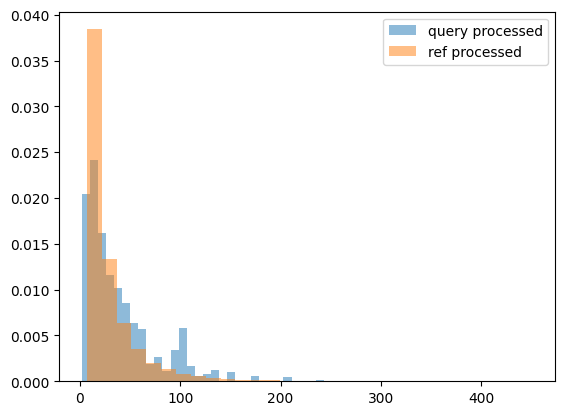

In [38]:
len_z_query= np.array([len(s.mz) for s in all_spectrums_janssen_processed] , )
_=plt.hist(len_z_query[np.random.randint(0,len(len_z_query), 1000)], bins=30, alpha=0.5, label='query processed', density=True)
len_z_ref= np.array([len(s.mz) for s in all_spectrums_reference_processed], )
_=plt.hist(len_z_ref[np.random.randint(0,len(len_z_ref), 10000)], bins=30, alpha=0.5,label='ref processed' , density=True)
plt.legend()

In [39]:
import random
random.random()

0.41400030337630367

In [40]:
min(len_z_ref)

7

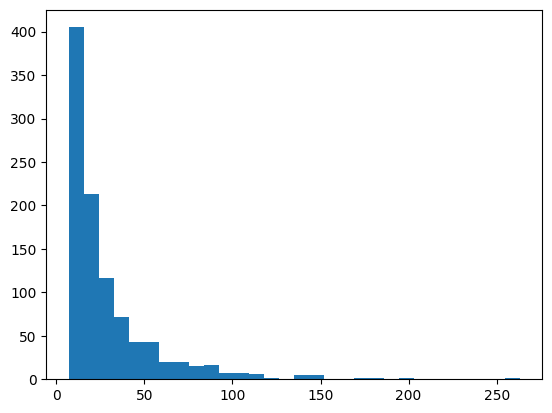

In [41]:
_=plt.hist(len_z_ref[np.random.randint(0,len(len_z_ref), 1000)], bins=30)

In [42]:
#proportion of spectra that is lower than 20
len_z_ref[len_z_ref<40].shape[0]/len_z_ref.shape[0]

0.7984233994308411

## Find those instances that are not in reference

In [43]:
canon_smiles_reference = [Chem.CanonSmiles(s.smiles) for s in all_spectrums_reference]
canon_smiles_janssen =   [Chem.CanonSmiles(s.smiles) for s in all_spectrums_janssen]
janssen_indexes_in_ref= [i for i,s in enumerate(canon_smiles_janssen) if s in canon_smiles_reference]
janssen_indexes_not_in_ref = [i for i,s in enumerate(canon_smiles_janssen) if s not in canon_smiles_reference]

In [44]:
len(janssen_indexes_in_ref),len(janssen_indexes_not_in_ref)

(26, 132)

In [45]:
all_spectrums_janssen = [all_spectrums_janssen[index] for index in janssen_indexes_not_in_ref]

In [46]:
all_spectrums_janssen[0].mz

array([ 50.65100861,  52.45254517,  53.03885651,  55.01812363,
        55.05448532,  57.03388214,  59.04931259,  61.02862549,
        67.05413055,  69.02909851,  69.03359222,  69.03674316,
        71.01267242,  71.04923248,  73.02831268,  78.26439667,
        78.26875305,  81.03349304,  81.92404938,  83.04917145,
        83.0537262 ,  85.02843475,  87.04410553,  87.04886627,
        91.03888702,  92.27946472,  95.04914856,  97.02849579,
        99.04411316, 101.0595856 , 109.0284195 , 111.0440598 ,
       111.0528107 , 113.0233078 , 113.0596695 , 115.0389633 ,
       116.9258041 , 125.0233231 , 126.2324829 , 127.0388947 ,
       128.6033478 , 129.0545349 , 129.0707855 , 133.0491791 ,
       145.0497284 , 162.7486267 , 164.9963684 , 173.0807648 ,
       179.9496155 , 189.0759888 , 221.1672058 , 313.0704346 ,
       325.070282  , 355.0821228 , 361.1105957 , 369.0095825 ,
       369.1330261 , 405.0971375 , 423.1092834 , 733.0827637 ])

## load encoder

In [47]:
encoder= Encoder(model_path, D_MODEL=int(config.D_MODEL),
                 N_LAYERS=int(config.N_LAYERS), 
                 multitasking=MULTITASKING, 
                 config=config)

## data loader

In [48]:
dataset_janssen= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_janssen, max_num_peaks=int(config.TRANSFORMER_CONTEXT),)
#dataset_janssen= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_janssen, max_num_peaks=20,)
dataloader_janssen= DataLoader(dataset_janssen, batch_size=config.BATCH_SIZE,  num_workers=0)

Preprocessing all the data ...


132it [00:00, 42211.66it/s]

Finished preprocessing 
loading data
Normalizing intensities


In [49]:
dataset_reference= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_reference,  max_num_peaks=int(config.TRANSFORMER_CONTEXT),)
#dataset_reference= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_reference, max_num_peaks=20,)
dataloader_reference= DataLoader(dataset_reference, batch_size=config.BATCH_SIZE,  num_workers=0)

Preprocessing all the data ...


328555it [00:03, 88859.65it/s]


Finished preprocessing 
loading data
Normalizing intensities


In [50]:
#dataset_nist= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_nist)
#dataloader_nist= DataLoader(dataset_nist, batch_size=config.BATCH_SIZE,  num_workers=0)

In [51]:
#dataset_gnps= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_gnps)
#dataloader_gnps= DataLoader(dataset_gnps, batch_size=config.BATCH_SIZE,  num_workers=0)

tensor([[0.2882, 0.5820, 0.1647,  ..., 0.0000, 0.0000, 0.0000],
        [0.1089, 0.3308, 0.5901,  ..., 0.0000, 0.0000, 0.0000],
        [0.2225, 0.3616, 0.1025,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1490, 0.0842, 0.1370,  ..., 0.0000, 0.0000, 0.0000],
        [0.0998, 0.0855, 0.0567,  ..., 0.0000, 0.0000, 0.0000],
        [0.0570, 0.0699, 0.0944,  ..., 0.0000, 0.0000, 0.0000]])


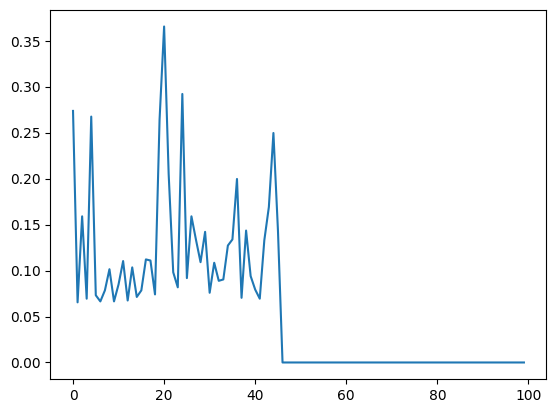

In [52]:
for batch in dataloader_reference:
    batch_example=batch
    print(batch['intensity'])
    plt.plot(batch['intensity'][10])
    break

## forward

In [53]:
embeddings_janssen= encoder.get_embeddings(dataloader_janssen)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)


In [54]:
embeddings_reference = encoder.get_embeddings(dataloader_reference)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

In [55]:
#embeddings_nist = encoder.get_embeddings(dataloader_nist)

In [56]:
#embeddings_gnps = encoder.get_embeddings(dataloader_gnps)

## compute similarities simba

In [57]:
config.use_cosine_distance

True

In [58]:
config.EDIT_DISTANCE_USE_GUMBEL

False

In [59]:

## In this context we are treating similarities2 as edit distance
#if config.use_cosine_distance:
#    #similarities1= CosineSimilarity.batch_cosine_similarity_combinations(embeddings_janssen, embeddings_reference)
#else:
similarities2, similarities1=FcLayerAnalogDiscovery.compute_all_combinations(model_path, 
                                                                                 embeddings_janssen, 
                                                                                 embeddings_reference, 
                                                                                 config)
## postprocessing similarities1
## we can't get similarities higher than 1.0
#similarities1[similarities1>1]=1

132it [01:52,  1.17it/s]


In [60]:
similarities2[0,0]

array([ 1.34812438,  0.8963722 ,  0.14013293, -0.96299756, -2.69532561,
       -6.3233428 ])

In [61]:
similarities1[0,0]

0.1222950890660286

In [62]:
similarities1.shape

(132, 328555)

In [63]:
similarities2.shape

(132, 328555, 6)

In [64]:
similarities2_norm = np.argmax(similarities2, axis=2)/5

In [65]:
similarities2_norm.shape

(132, 328555)

(array([205.,  67.,  77., 265., 186.,  85.,  43.,  38.,  24.,  10.]),
 array([0.        , 0.07321077, 0.14642154, 0.21963231, 0.29284308,
        0.36605385, 0.43926462, 0.51247539, 0.58568616, 0.65889693,
        0.7321077 ]),
 <BarContainer object of 10 artists>)

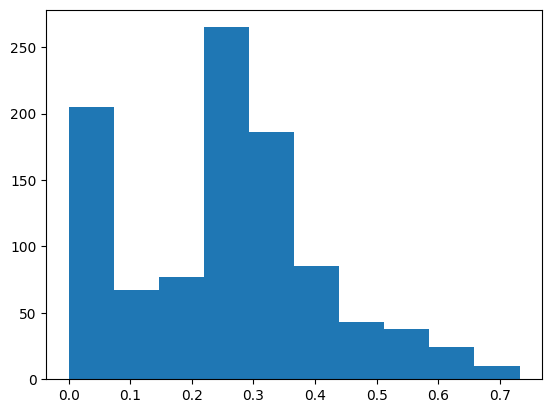

In [66]:
plt.hist(similarities1.reshape(-1)[0:1000])

In [67]:
(similarities2_norm>0)

array([[False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [68]:
similarities1.shape[0]*similarities1.shape[1]

43369260

In [69]:
similarities1[(similarities1>0.9)].shape

(242978,)

In [70]:
# how many pairs have high similarity1 
similarities1[(similarities1>0.9)&(similarities2_norm < 0.5)].shape

(3826,)

In [71]:
similarities1[(similarities1>0.9)].shape

(242978,)

In [72]:
# how many pairs have high similarity1 and low similarity 2?
similarities1[similarities1>=1].shape

(0,)

In [73]:
similarities2_norm

array([[0. , 0. , 0. , ..., 0. , 0. , 0.2],
       [0. , 0. , 0. , ..., 0. , 0. , 0.4],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0.2],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [74]:
# how many pairs have high similarity1  and low similarity 2?
similarities1[(similarities1>=0.75)].shape

(1492433,)

In [75]:
# how many pairs have high similarity1  and low similarity 2?
similarities1[(similarities1>0.75)&(similarities2_norm==0)].shape

(247021,)

## Combine both metrics

In [76]:
def softmax(x):
    # Subtract the maximum value in the last dimension to stabilize the computation
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)
similarities2_softmax= softmax(similarities2)

In [77]:
ranking_1 = np.zeros(similarities1.shape)
for row_index, row_similarities in enumerate(similarities1):
    indexes_sorted= np.argsort(row_similarities)[::-1]
    ranking_1[row_index] = np.argsort(indexes_sorted)

#normalize
ranking_1 = 1- ranking_1/np.max(ranking_1)

In [214]:
similarities2_integer = similarities2_norm*5

In [207]:
similarities1_integer = np.array((similarities1*40), dtype=np.int32)

In [346]:
import numpy as np

def compute_ranking(similarities1, similarities1_integer, similarities2_integer, max_value_2_int=5):
    # Preallocate the ranking array with the same shape as similarities1.
    ranking_total = np.zeros(similarities1.shape, dtype=int)
    
    # Process each row (or each set of values) individually.
    for row_index, (row_sim, row_int, row_int2) in enumerate(zip(similarities1, similarities1_integer, similarities2_integer)):
        # Use lexsort with a composite key:
        #   - Primary: similarities1_integer (ascending)
        #   - Secondary: similarities2_integer (ascending)
        #   - Tertiary: similarities1 (descending, so use -row_sim)
        #
        # Note: np.lexsort uses the last key as the primary key.
        sorted_indices = np.lexsort( ( row_sim, row_int2, row_int ) )
        
        # Now assign ranking values based on sorted order.
        # Here the best (first in sorted_indices) gets rank 0,
        # the next gets rank 1, etc.
        ranking = np.empty_like(sorted_indices)
        ranking[sorted_indices] = np.arange(len(row_sim))
        
        # Store the ranking for this row.
        ranking_total[row_index] = ranking

    #normalizing
    ranking_total =ranking_total/ranking_total.shape[1]
    return ranking_total

In [347]:
ranking_total= compute_ranking(similarities1, similarities1_integer, similarities2_integer)

In [78]:
np.max(ranking_1)

1.0

In [79]:
## the first 100 positions
proportion1000= 1000/len(all_spectrums_reference)

In [80]:
proportion1000

0.0030436304423916848

In [81]:
np.min(ranking_1)

0.0

In [82]:
# based on edit distance=0 output
#similarities2_ed5_complementary=1-similarities2_softmax[:,:,0]
#ranking_2 = np.zeros(similarities2_ed5_complementary.shape)
#for row_index, row_similarities in enumerate(similarities2_ed5_complementary):
#    indexes_sorted= np.argsort(row_similarities)[::-1]
#    ranking_2[row_index] = np.argsort(indexes_sorted)
#ranking_2 = 1- ranking_2/np.max(ranking_2)

import pandas as pd
# based on similarity norm
def normalize_ranks(values):
    # Convert values to a numpy array for processing
    original_shape=values.shape
    values=np.reshape(values, (-1))
    values = np.array(values)
    
    # Get ranks using pandas (average ranking for ties)
    ranks = pd.Series(values).rank(method='average').to_numpy()
    
    # Normalize ranks to [0, 1]
    normalized_ranks = (ranks - 1) / (len(values) - 1)

    normalized_ranks= np.reshape(normalized_ranks, original_shape)
    return normalized_ranks

# Get normalized ranks
ranking_2 = normalize_ranks(similarities2_norm)



In [83]:
similarities1.shape

(132, 328555)

In [84]:
similarities1[similarities1>0.9].shape

(242978,)

In [85]:
similarities1[(similarities2_norm>0) &(similarities1>0.90)].shape

(242132,)

In [348]:
## combine both metrics
#similarities= similarities1
similarities= ranking_total
#similarities= similarities1*(similarities2_norm>0)
#similarities= ((ranking_1+ranking_2)/2)
#similarities = ((ranking_1+ranking_2)/2) *(ranking_1> (1-proportion1000))*(ranking_2>(1-proportion1000))
#similarities = similarities1 *(ranking_1> (0.95))*(ranking_2>(0.95))  ### this soft filtering improves a little bit the results
#similarities= similarities1*(similarities2_norm>0)
#similarities = similarities1*(similarities2_softmax[:,:,0]<0.1)

In [349]:
similarities1[similarities1>0.95].shape

(85794,)

In [350]:
similarities1[(similarities1>0.95) & (similarities2_norm>0.0)].shape

(85761,)

In [351]:
similarities1[(similarities1>0.95) & (similarities2_softmax[:,:,0]<0.10)].shape

(84840,)

In [352]:
#similarities= similarities1*(similarities1<0.98) + similarities1*((similarities1>=0.98) & (similarities2_softmax[:,:,0]<0.01))

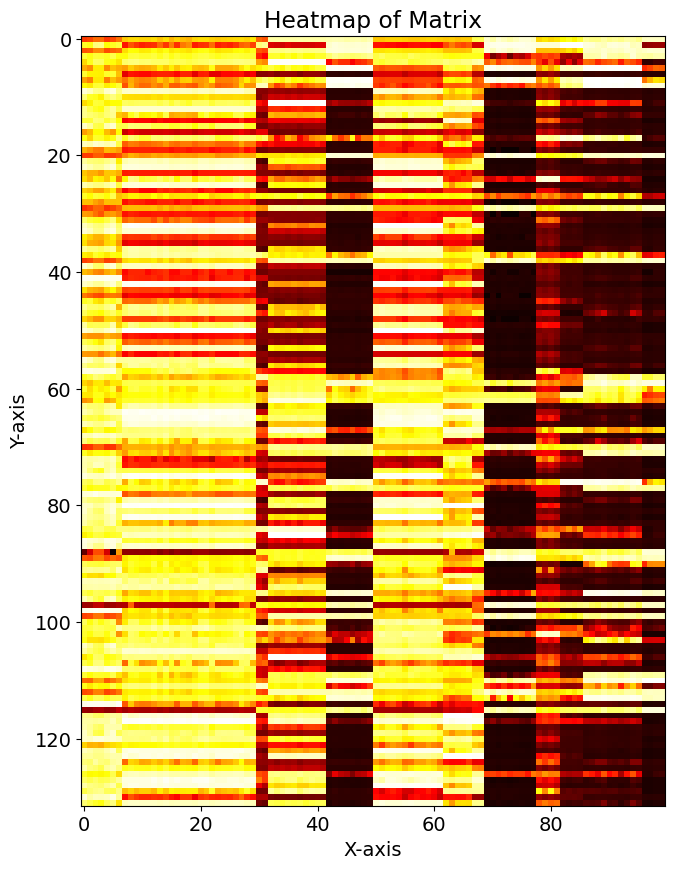

In [353]:
plt.figure(figsize=(10,10))
plt.imshow(similarities[:, 0:100], cmap='hot', interpolation='nearest')
#plt.colorbar()  # Add colorbar to show scale
plt.title('Heatmap of Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [354]:
all_spectrums_reference[3].params

{'smiles': 'CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC',
 'inchikey': 'VFMQMACUYWGDOJ',
 'formula': 'C16H17NO4',
 'precursor_formula': 'C16H18NO4',
 'parent_mass': '287.115224',
 'precursor_mz': '288.1225',
 'adduct': '[M+H]+',
 'instrument_type': 'Orbitrap',
 'collision_energy': '55.0',
 'fold': 'train',
 'simulation_challenge': 'True'}

In [355]:
smiles=[s.params['smiles'] for s in all_spectrums_reference]

In [356]:
for i,s in enumerate(smiles[0:1000]):
    print(f'index{i}   {s}') 

index0   CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC
index1   CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC
index2   CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC
index3   CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC
index4   CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC
index5   CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC
index6   CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC
index7   C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(=CC(=C2)O)O)C(=O)O1
index8   C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(=CC(=C2)O)O)C(=O)O1
index9   C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(=CC(=C2)O)O)C(=O)O1
index10   C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(=CC(=C2)O)O)C(=O)O1
index11   C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(=CC(=C2)O)O)C(=O)O1
index12   C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(=CC(=C2)O)O)C(=O)O1
index13   C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(=CC(=C2)O)O)C(=O)O1
index14   C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(=CC(=C2)O)O)C(=O)O1
index15   C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(=CC(=C2)O)O)C(=O)O1
index16   C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(=CC(=C2)O)O)C(=O)O1
index17   C[C@H]1C

## Check distribution of outputs

In [357]:
N=1000
random_j= np.random.randint(0,similarities.shape[0],N)
random_r=np.random.randint(0,similarities.shape[1],N)

(array([ 56.,  16.,  18.,  15.,  24.,  27.,  47.,  82., 152., 153., 133.,
        102.,  69.,  40.,  28.,  17.,   6.,  10.,   2.,   3.]),
 array([0.        , 0.04888259, 0.09776518, 0.14664777, 0.19553035,
        0.24441294, 0.29329553, 0.34217812, 0.39106071, 0.4399433 ,
        0.48882589, 0.53770848, 0.58659106, 0.63547365, 0.68435624,
        0.73323883, 0.78212142, 0.83100401, 0.8798866 , 0.92876919,
        0.97765177]),
 <BarContainer object of 20 artists>)

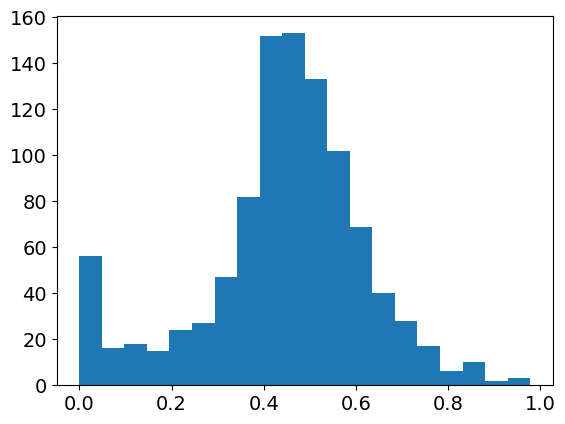

In [358]:
plt.hist(similarities1[random_j,random_r], bins=20)

(array([723.,   0.,   0.,   0., 148.,   0.,   0.,   0.,  48.,   0.,   0.,
         36.,   0.,   0.,   0.,   0.,  33.,   0.,   0.,  12.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

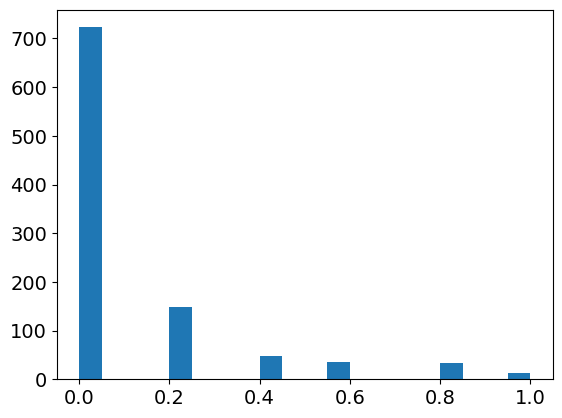

In [359]:
plt.hist(similarities2_norm[random_j,random_r], bins=20)

(array([46., 53., 43., 67., 65., 50., 51., 46., 47., 47., 43., 43., 44.,
        57., 47., 58., 54., 48., 47., 44.]),
 array([8.43085633e-04, 5.07289495e-02, 1.00614813e-01, 1.50500677e-01,
        2.00386541e-01, 2.50272405e-01, 3.00158269e-01, 3.50044133e-01,
        3.99929996e-01, 4.49815860e-01, 4.99701724e-01, 5.49587588e-01,
        5.99473452e-01, 6.49359316e-01, 6.99245180e-01, 7.49131044e-01,
        7.99016907e-01, 8.48902771e-01, 8.98788635e-01, 9.48674499e-01,
        9.98560363e-01]),
 <BarContainer object of 20 artists>)

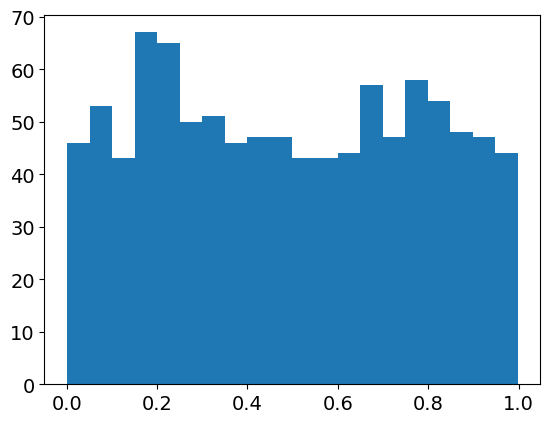

In [360]:
plt.hist(similarities[random_j,random_r], bins=20)

## Retrieval of best candidates

In [361]:
similarities.shape

(132, 328555)

In [362]:
spectrums_k_retrieved, tanimoto_k_retrieved, sim_k_retrieved, arg_max_k10 =\
                AnalogDiscovery.get_k_candidates(similarities, all_spectrums_reference, 
                                                 all_spectrums_janssen,k=10, return_arg_max_k10=True)

In [363]:
arg_max_k10

array([[ 84365, 304489, 304488, ...,  50557,  64312, 214264],
       [ 67606,  78418,  71001, ..., 271922, 306038, 305524],
       [ 80198,  89623, 138474, ...,  90217,  42362,  93601],
       ...,
       [125558, 258045,  21209, ...,  67618,  32394, 222869],
       [ 40659,  40676,  40655, ...,  86551,  40674, 274626],
       [113184, 113183, 113185, ..., 113182, 113703,  93685]])

In [364]:
from src.analog_discovery.mces import MCES
if USE_MCES_RAW:
    mces_k_retrieved= []
    for s_group, spec_janssen in zip(spectrums_k_retrieved,all_spectrums_janssen):
        smiles_0 = [s.params['smiles'] for s in s_group]
        smiles_1 = [spec_janssen.params['smiles']]*len(s_group)
        df = MCES.compute_mces_list_smiles(smiles_0, smiles_1, threshold_mces=20)
        mces_k_retrieved.append(df['mces'].values)
else:
    mces_k_retrieved = [[MCES.calculate_mces_sim(s.params['smiles'], spec_janssen.params['smiles']) for s in s_group] for s_group, spec_janssen in zip(spectrums_k_retrieved,all_spectrums_janssen)]

Too many matching bond pairs (1119) so can't continue.
Too many matching bond pairs (1114) so can't continue.
Too many matching bond pairs (1107) so can't continue.
Too many matching bond pairs (1147) so can't continue.
Too many matching bond pairs (1147) so can't continue.
Too many matching bond pairs (1107) so can't continue.
Too many matching bond pairs (1104) so can't continue.
Too many matching bond pairs (1144) so can't continue.
Too many matching bond pairs (1114) so can't continue.
Too many matching bond pairs (1107) so can't continue.
Too many matching bond pairs (1073) so can't continue.
Too many matching bond pairs (1073) so can't continue.
Too many matching bond pairs (1073) so can't continue.
Too many matching bond pairs (1073) so can't continue.
Too many matching bond pairs (1073) so can't continue.
Too many matching bond pairs (1045) so can't continue.
Too many matching bond pairs (1045) so can't continue.
Too many matching bond pairs (1045) so can't continue.
Too many m

Timed out after 61 seconds.
Timed out after 61 seconds.


Too many matching bond pairs (1147) so can't continue.
Too many matching bond pairs (1147) so can't continue.
Too many matching bond pairs (1147) so can't continue.
Too many matching bond pairs (1136) so can't continue.
Too many matching bond pairs (1136) so can't continue.
Too many matching bond pairs (1113) so can't continue.
Too many matching bond pairs (1147) so can't continue.
Too many matching bond pairs (1147) so can't continue.
Too many matching bond pairs (1147) so can't continue.
Too many matching bond pairs (1073) so can't continue.
Too many matching bond pairs (1614) so can't continue.
Too many matching bond pairs (1665) so can't continue.
Too many matching bond pairs (1665) so can't continue.
Too many matching bond pairs (1652) so can't continue.
Too many matching bond pairs (1597) so can't continue.
Too many matching bond pairs (1584) so can't continue.
Too many matching bond pairs (1526) so can't continue.
Too many matching bond pairs (1526) so can't continue.
Too many m

In [365]:
#mces_k_retrieved = [[MCES.calculate_mces_sim(s.params['smiles'], spec_janssen.params['smiles']) for s in s_group] for s_group, spec_janssen in zip(spectrums_k_retrieved,all_spectrums_janssen)]

In [366]:
#best_indexes = [np.argmax(tani_group[0:10]) if len(tani_group)>=1 else None for tani_group in tanimoto_k_retrieved ]
#best_indexes = [np.argmax([m for m in mces_group if m is not None][0:10]) if len(mces_group)>=1 else None for mces_group in tanimoto_k_retrieved ]
#best_indexes = [np.argmax([m for m in mces_group if m is not None]) if len(mces_group)>=0 else 0 for mces_group in tanimoto_k_retrieved ]
#best_indexes = [np.argmax([m for m in mces_group if m is not None]) if len(mces_group)>=0 else 0 for mces_group in mces_k_retrieved ]
if USE_MCES_RAW:
    best_indexes = [np.argmin([m for m in mces_group if m is not None]) if len(mces_group)>=0 else 0 for mces_group in mces_k_retrieved ]
else: #if using normalized similarity
    best_indexes = [np.argmax([m for m in mces_group if m is not None]) if len(mces_group)>=0 else 0 for mces_group in mces_k_retrieved ]

In [367]:
# get the best tanimotos
spectrums_retrieved = [spectrums_k_retrieved[index_spectrum][best_index]  for index_spectrum, best_index in enumerate(best_indexes) if best_index is not None]
tanimoto_retrieved = [tanimoto_k_retrieved[index_spectrum][best_index]  for index_spectrum, best_index in enumerate(best_indexes) if best_index is not None]
mces_sims = [mces_k_retrieved[index_spectrum][best_index]  for index_spectrum, best_index in enumerate(best_indexes) if best_index is not None]

max_sim = [sim_k_retrieved[index_spectrum][best_index]  for index_spectrum, best_index in enumerate(best_indexes) if best_index is not None]

In [368]:
# retrieve of the edit distance result
ed_pred_retrieved= [similarities2_softmax[index_spectrum ,arg_max_k10[index_spectrum]]     for index_spectrum, best_index in enumerate(best_indexes) if best_index is not None]
ed_sim = [similarities2_softmax[index_spectrum ,arg_max_k10[index_spectrum][best_index]]     for index_spectrum, best_index in enumerate(best_indexes) if best_index is not None]


In [369]:
smiles_retrieved= [s.smiles for s in spectrums_retrieved]

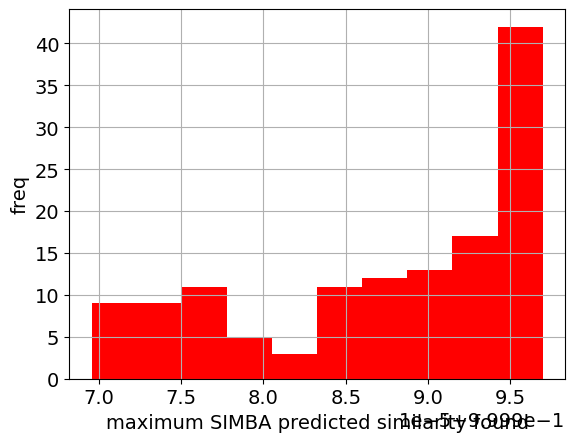

In [370]:
_=plt.hist(max_sim, color='r', bins=10)
plt.xlabel('maximum SIMBA predicted similarity found')
plt.ylabel('freq')
plt.grid()

(0.0, 3.5)

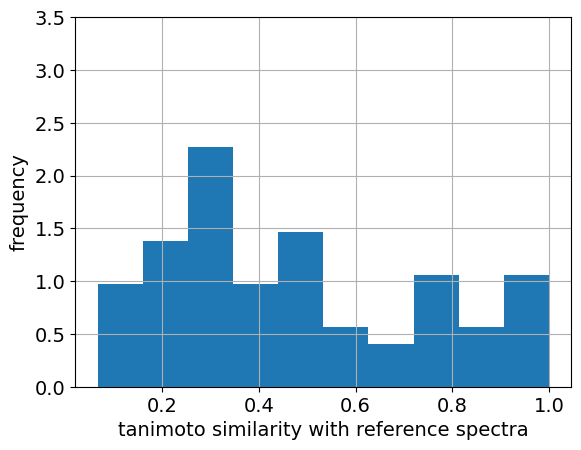

In [371]:
plt.hist(tanimoto_retrieved,density=True, bins=10)
plt.grid()
plt.xlabel('tanimoto similarity with reference spectra')
plt.ylabel('frequency')
plt.ylim([0,3.5])

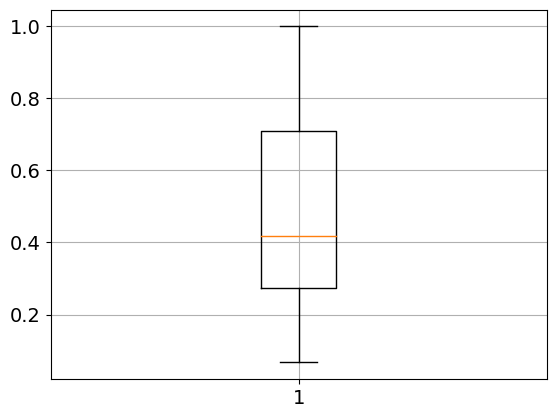

In [372]:
plt.boxplot(tanimoto_retrieved)
plt.grid()

In [373]:
all_smiles_janssen = [s.params['smiles'] for s in all_spectrums_janssen]

In [374]:
smiles_retrieved

['C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)OC[C@@H]2[C@H]([C@@H]([C@H]([C@@H](O2)OC3=C(C(=C4C(=C3)OC(=CC4=O)C5=CC=C(C=C5)OC)O)OC)O)O)O)OC(=O)C)OC(=O)C)O',
 'CCOC(=O)CCN(C1=CC=CC=N1)C(=O)C2=CC3=C(C=C2)N(C(=N3)CNC4=CC=C(C=C4)C(=N)N)C',
 'CCCC(=O)OC[C@H]([C@H]([C@H](CN1C2=C(C=C(C(=C2)C)C)N=C3C1=NC(=O)NC3=O)OC(=O)CCC)OC(=O)CCC)OC(=O)CCC',
 'CC1CCC2(CCC3(C(=CCC4C3(CCC5C4(CCC(C5(C)C(=O)O)O)C)C)C2C1(C)O)C)C(=O)O',
 'C1=CC=C2C(=C1)C(=O)OC2(C3=CC=C(C=C3)C(=O)O)C4=CC=C(C=C4)C(=O)O',
 'CCCC1=NN(C2=C1NC(=NC2=O)C3=C(C=CC(=C3)S(=O)(=O)N4CCN(CC4)C)OCC)C',
 'C1=CC=C(C=C1)CCC(=O)NCC(=O)O',
 'CCCC1=NC(=C2N1NC(=NC2=O)C3=C(C=CC(=C3)S(=O)(=O)N4CCN(CC4)CC)OCC)C',
 'CCCCCCCCCCCCCCCC(C(CO)NC(=O)CCCCCNC1=CC=C(C2=NON=C12)[N+](=O)[O-])O',
 'CC1=C2C3C(CCC2(CCC1)C)(C(=C)C(=O)O3)O',
 'CC1=C(C=CC(=O)O1)CCCC(=O)O',
 'COC1=CC(=CC(=C1OC)OC)C2=C(C(=O)C3=C(O2)C=C(C(=C3O)OC)O)OC',
 'CCC1=CC(=O)OC2=CC(=C(C=C12)OC)OC',
 'CC(=CC(=O)O)CCC1C(=C)CCC2C1(CCCC2(C)C)C',
 'COC1=CC2=C(C=C1)C3=C4N2C(=O)C=CC4=NC=C3',
 'CC1C(=O)OC2C1(CCC3(C2

In [375]:
mces_sims=[]
for s0,s1 in tqdm(zip(all_smiles_janssen, smiles_retrieved)):
    similarity= MCES.calculate_mces_sim(s0, s1)
    mces_sims.append(similarity)

1it [00:00,  5.07it/s]Too many matching bond pairs (1114) so can't continue.
71it [00:01, 38.36it/s] Too many matching bond pairs (1045) so can't continue.
Too many matching bond pairs (1073) so can't continue.
78it [00:01, 38.70it/s]Too many matching bond pairs (1043) so can't continue.
Too many matching bond pairs (1348) so can't continue.
98it [01:05,  2.45s/it]

Timed out after 61 seconds.


Too many matching bond pairs (1147) so can't continue.
Too many matching bond pairs (1665) so can't continue.
114it [01:06,  1.31s/it]Too many matching bond pairs (2859) so can't continue.
132it [01:06,  1.99it/s]


In [376]:


# best indexes taking into account ED threshold
valid_ed_predictions = [ [p if p[0]<0.1 else  None for p in p_list] for p_list in ed_pred_retrieved]
best_indexes_ed= [[s if v is not None else 0 for s,v in zip(s_list,v_list) ] for v_list,s_list in zip(valid_ed_predictions, sim_k_retrieved)]
best_indexes_ed = [np.argmax(b) if np.max(b)>0 else None for b in best_indexes_ed]
smiles_retrieved_ed = [spectrums_k_retrieved[index_spectrum][best_index].params['smiles']  if best_index is not None else None for index_spectrum, best_index in enumerate(best_indexes_ed) ]
mces_sims_ed=[]
for s0,s1 in tqdm(zip(all_smiles_janssen, smiles_retrieved_ed)):
    if s1 is not None:
        similarity= MCES.calculate_mces_sim(s0, s1)
        mces_sims_ed.append(similarity)

1it [00:00,  4.07it/s]Too many matching bond pairs (1119) so can't continue.
30it [00:00, 57.32it/s]Too many matching bond pairs (1073) so can't continue.
61it [00:03, 16.20it/s]Too many matching bond pairs (1045) so can't continue.
Too many matching bond pairs (1137) so can't continue.
85it [00:19,  3.37it/s]Too many matching bond pairs (1348) so can't continue.
98it [00:23,  3.47it/s]Too many matching bond pairs (1147) so can't continue.
Too many matching bond pairs (1614) so can't continue.
Too many matching bond pairs (2859) so can't continue.
132it [00:23,  5.60it/s]


Proportion of confident predictions: 0.36363636363636365
Median of confident predictions: 0.8453476008555568


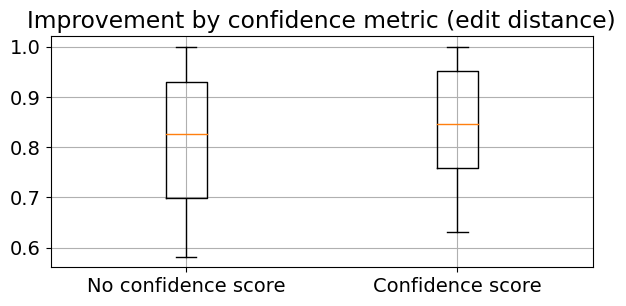

In [377]:
mces_without_confidence= [m for m in mces_sims if m is not None]
mces_with_confidence= [m for m,ed in zip(mces_sims, ed_sim) if ((m is not None)and (ed[0]<0.01))]

plt.figure(figsize=(7,3))
plt.title('Improvement by confidence metric (edit distance)')
plt.boxplot([mces_without_confidence,mces_with_confidence], labels= ['No confidence score', 'Confidence score'])
#plt.boxplot(mces_with_confidence)
#plt.boxplot([m for m in mces_retrieved if m is not None])
plt.grid()
print(f'Proportion of confident predictions: {len(mces_with_confidence)/len(mces_without_confidence)}')
print(f'Median of confident predictions: {np.median(mces_with_confidence)}')
#plt.ylim([0,1.1])

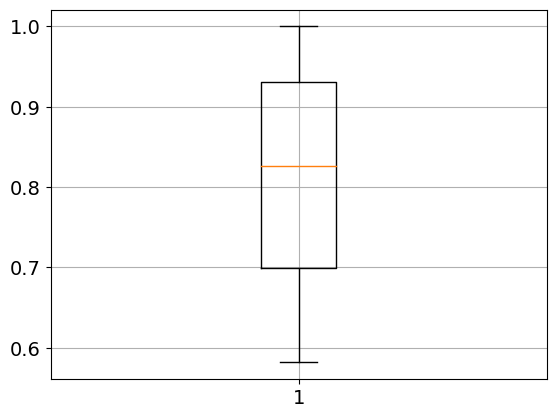

In [378]:
plt.boxplot([m for m in mces_sims if m is not None])
#plt.boxplot([m for m in mces_retrieved if m is not None])
plt.grid()
#plt.ylim([0,1.1])

In [379]:
np.median([m for m in mces_sims if m is not None])

0.82633394197606

## Sanity check

In [380]:
from src.ordinal_classification.embedder_multitask import EmbedderMultitask

In [381]:
target_janssen_index= 0
target_ref_index=np.argsort(similarities[target_janssen_index])[::-1][0]


In [382]:
spec_ref=    all_spectrums_reference[target_ref_index]
spec_janssen=all_spectrums_janssen[target_janssen_index]

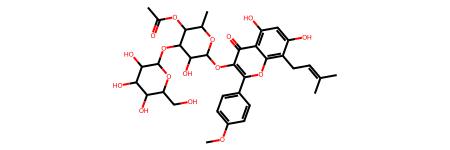

In [383]:
# query molecule
Chem.MolFromSmiles(spec_janssen.params['smiles'])

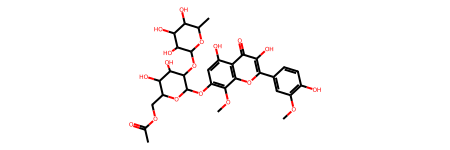

In [384]:
# reference molecule
Chem.MolFromSmiles(spec_ref.params['smiles'])

In [385]:
smiles_ref= spec_ref.params['smiles']
smiles_janssen= spec_janssen.params['smiles']

In [386]:
from src.tanimoto import Tanimoto

In [387]:
Tanimoto.compute_tanimoto_from_smiles(smiles_ref,smiles_janssen)

0.7661388550548112

In [388]:
# mces 20
mces_norm = similarities1[target_janssen_index, target_ref_index]
print(f'mces distance: {config.MCES20_MAX_VALUE*(1-mces_norm)}')

mces distance: 0.056612491607666016


In [389]:
# edit distance
ed_vector=similarities2[target_janssen_index, target_ref_index]
print(ed_vector)
print(f'Edit distance found: {5-np.argmax(ed_vector)} modifications')

[-2.78028083 -2.85219049 -2.33405614 -1.32364523  0.37637743  0.64793456]
Edit distance found: 0 modifications


In [390]:
similarities1[similarities1>0.99].shape

(6384,)

In [391]:
ed_total=np.argmax(similarities2, axis=2)
ed_total=ed_total.reshape(-1)
ed_total[ed_total==5].shape

(790771,)

In [392]:
ed_total[ed_total==5].shape[0]/(ed_total.shape[0])

0.01823344461030693

In [393]:
similarities1[similarities1>0.99].shape[0]/(similarities1.shape[0]*similarities1.shape[1])

0.00014720103594112512

## Let's make the ROC curve

In [394]:
## 1) for the roc curve we have to get a set of true MCES similarities 
## get the MCES predicted by the model
## compute the num bonds for each molecule of the pair
## compute similarity based on the distance computed

In [395]:
number_examples=10000

In [396]:
random_indexes_0= np.random.randint(0,len(all_spectrums_janssen),number_examples)

In [397]:
random_indexes_1=np.random.randint(0,len(all_spectrums_reference),number_examples)

In [398]:
# get the spectra
spectrums_random_0 = [all_spectrums_janssen[index] for index in random_indexes_0]
spectrums_random_1 = [all_spectrums_reference[index] for index in random_indexes_1]

In [399]:

def softmax(x):
    # Subtract the maximum value in the last dimension to stabilize the computation
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

similarities2_softmax= softmax(similarities2)

In [400]:
similarities2_softmax[0,0]

array([4.87219867e-01, 3.10121237e-01, 1.45579749e-01, 4.83078249e-02,
       8.54430942e-03, 2.27012161e-04])

In [401]:
## compute ground truth
mces20_groundtruth = []
for s0,s1 in tqdm(zip(spectrums_random_0, spectrums_random_1)):
    similarity= MCES.calculate_mces_sim(s0.params['smiles'], s1.params['smiles'],similarity_threshold=0.7)
    mces20_groundtruth.append(similarity)

0it [00:00, ?it/s]Too many matching bond pairs (1584) so can't continue.
2275it [00:02, 926.34it/s]Too many matching bond pairs (1074) so can't continue.
3432it [00:04, 600.22it/s]Too many matching bond pairs (2593) so can't continue.
Too many matching bond pairs (1428) so can't continue.
4200it [00:04, 1189.57it/s]Too many matching bond pairs (1241) so can't continue.
Too many matching bond pairs (1143) so can't continue.
6934it [00:10, 287.36it/s] Too many matching bond pairs (1033) so can't continue.
8770it [00:11, 953.26it/s]Too many matching bond pairs (1601) so can't continue.
9213it [00:11, 1268.71it/s]Too many matching bond pairs (1154) so can't continue.
10000it [00:11, 874.06it/s]


In [402]:
num_bonds_0 = [Chem.MolFromSmiles(s.params['smiles']).GetNumBonds() for s in spectrums_random_0]
num_bonds_1 = [Chem.MolFromSmiles(s.params['smiles']).GetNumBonds() for s in spectrums_random_1]

In [403]:
threshold=0.7
thresholds_ed=[1, 0.1]
colors= ['b','r','g']

In [404]:
## try different thresholds
y_true_list =[]
y_scores_list=[]
coverage_list=[]
for threshold_ed5, color in zip(thresholds_ed, colors):
    # use the edit distance
    similarities_roc= get_similarities_combined(similarities1, similarities2_softmax,threshold_ed5)

    mces20 = 40*(1-similarities_roc)

    # sample based on ed
    mces20_sampled = [mces20[index_0, index_1] for index_0, index_1 in zip(random_indexes_0, random_indexes_1)]

    predicted_similarity =  [((n0+n1)-m20)/(n0+n1)  for n0,n1,m20 in zip(num_bonds_0,num_bonds_1, mces20_sampled)]

    
    valid_indexes = [i for i,m in enumerate(mces20_sampled) if m!=40 ]

    coverage=(len(valid_indexes)/len(mces20_sampled))
    coverage = coverage if coverage<0.98 else 1
    coverage=100*coverage #percentage

    mces20_groundtruth=np.array(mces20_groundtruth)
    predicted_similarity=np.array(predicted_similarity)

    y_true = [m if m is not None else 0 for m in mces20_groundtruth[valid_indexes] ]
    y_true=[1 if m>threshold else 0 for m in y_true]
    y_scores= predicted_similarity[valid_indexes]

    y_true_list.append(y_true)
    y_scores_list.append(y_scores)
    coverage_list.append(coverage)
    #Plotting.plot_roc_curve(
    #    y_true,
    #    y_scores,
    #    label=f'coverage: {coverage:.2f}%',
    #    color=color)
    #plt.grid()

fpr with tpr=0.70 [0.05424043 0.05526966 0.05526966 0.05835735 0.05835735 0.06010704
 0.06010704 0.06442981 0.06442981 0.06628242 0.06628242 0.06854673
 0.06854673 0.06926719 0.06926719 0.07317826 0.07317826 0.07904487
 0.07904487 0.08295595 0.08295595 0.09160148 0.09160148 0.09335117
 0.09355702 0.09355702 0.09448333 0.09448333 0.09540963 0.09540963
 0.09551256 0.09551256 0.10426101 0.10426101 0.10765747 0.10765747
 0.11311239 0.11311239 0.11383285 0.11383285 0.118979   0.118979
 0.12216962 0.12216962 0.12319885 0.12319885 0.12463977 0.12463977
 0.12958007 0.12958007 0.13122684 0.13122684 0.13287361 0.13287361
 0.14254837 0.14254837 0.15500206 0.15500206 0.15870729 0.15870729
 0.16107452 0.16107452 0.16580897 0.16580897 0.17795389 0.17795389
 0.1815562  0.1815562  0.18423219 0.18423219 0.19915603 0.19915603
 0.20913956 0.20913956 0.2151091  0.2151091  0.23744339 0.23744339
 0.24763277 0.24763277 0.26111569 0.26111569 0.28314121 0.28314121
 0.28797859 0.28797859 0.41292713 0.41292713 0

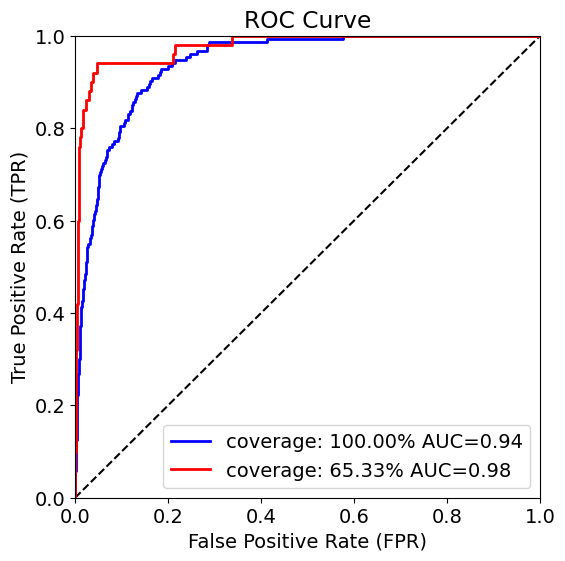

In [405]:
Plotting.plot_n_roc_curves(y_true_list, y_scores_list, labels=[f'coverage: {coverage:.2f}%' for coverage in coverage_list],
        colors=['b','r','g'],
        linestyles=['-','-','-'],
            figsize=(6,6))

In [406]:
len(mces20_sampled)

10000

In [407]:
mces20_groundtruth=np.array(mces20_groundtruth)
predicted_similarity=np.array(predicted_similarity)

Text(0.5, 0, 'mces normalized ground truth')

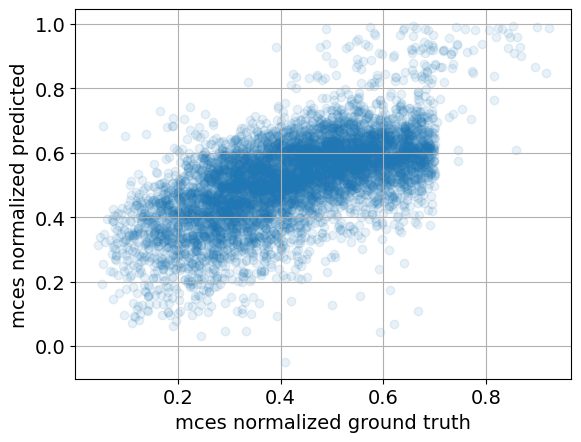

In [408]:
plt.scatter(mces20_groundtruth[valid_indexes], predicted_similarity[valid_indexes], alpha=0.1)
plt.grid()
plt.ylabel('mces normalized predicted')
plt.xlabel('mces normalized ground truth')

In [409]:
## compute roc curve


In [410]:
results ={ 'smiles_janssen' : [s.params['smiles'] for s in all_spectrums_janssen], 
        'smiles_reference' : [s.params['smiles'] for s in all_spectrums_reference], 
        'mces_retrieved':mces_sims,
          'similarities':similarities,
         }

In [411]:
with open('./notebooks/discovery_search/results/'+similarity_name + '_results_analog_discovery_unknwon_compounds.pkl', 'wb') as f:
    dill.dump(results, f)

## Use of raw mces

In [412]:
# let's use myopic

In [413]:
from src.mces.mces_computation import MCES

In [414]:
#mces_k_retrieved = [[MCES.calculate_mces_sim(s.params['smiles'], spec_janssen.params['smiles']) for s in s_group] for s_group, spec_janssen in zip(spectrums_k_retrieved,all_spectrums_janssen)]

In [415]:
#mces_retrieved_raw= []
#for s_group, spec_janssen in zip(spectrums_k_retrieved,all_spectrums_janssen):
#    smiles_0 = [s.params['smiles'] for s in s_group]
#    smiles_1 = [spec_janssen.params['smiles']]*len(s_group)
#    df = MCES.compute_mces_list_smiles(smiles_0, smiles_1, threshold_mces=20)
#    mces_retrieved_raw.append(df['mces'].values)

## Analysis of one example

In [416]:
target_index=58

In [417]:
target_query=all_spectrums_janssen[target_index]

In [418]:
smiles_query= target_query.params['smiles']

In [419]:
target_query.params

{'spectrumid': '238 M+H',
 'name': '238 M+H',
 'inchi': '',
 'organism': 'casmi',
 'id': 238,
 'smiles': 'CCCCCCCCCCCCCOC(=O)c1ccccc1C(=O)OCCCCCCCCCCCCC',
 'ionmode': 'Positive',
 'pepmass': [531.4400905022],
 'charge': [1],
 'libraryquality': 1}

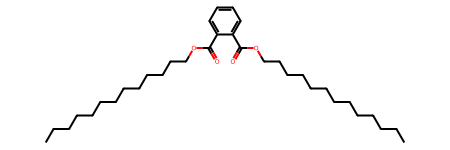

In [420]:
Chem.MolFromSmiles(smiles_query)

In [421]:
len(target_query.mz)

13

In [422]:
# load tanimotos
tanimoto_results_path = 'tanimoto_similarity_casmi_NEURIPS'
format_file_unknown = "./notebooks/discovery_search/results/{}_results_analog_discovery_unknwon_compounds.pkl"
with open(format_file_unknown.format(tanimoto_results_path), 'rb') as f:
                golden_truth= dill.load(f)['similarities']

In [423]:
## What is the best match based on tanimoto?
best_golden_truth_index=np.argsort(golden_truth[target_index])[::-1][0]

In [424]:
max_value=np.sort(golden_truth[target_index])[-1]
best_golden_truth_list = np.where(golden_truth[target_index]==max_value)[0]

In [425]:
best_golden_truth_list

array([299794, 299795, 299796, 299797, 310759, 310760, 310761, 310762,
       310763])

In [426]:
all_spectrums_reference[best_golden_truth_index].params

{'libraryquality': 1,
 'charge': [1],
 'pepmass': [391.2843],
 'ionmode': 'Positive',
 'name': ' Di-n-octyl phthalate\n M+H',
 'inchi': 'N/A',
 'smiles': 'CCCCCCCCOC(=O)C1=CC=CC=C1C(=O)OCCCCCCCC',
 'organism': 'nist',
 'spectrumid': 'abcd'}

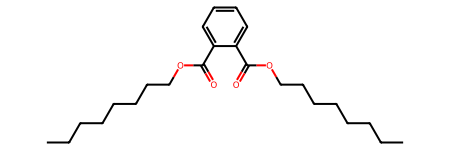

In [427]:
Chem.MolFromSmiles(all_spectrums_reference[best_golden_truth_index].params['smiles'])

In [428]:
len(all_spectrums_reference[best_golden_truth_index].mz)

9

In [429]:
len(target_query.mz)

13

In [430]:
similarities1.shape

(132, 328555)

## Define the desired ranking

In [431]:
rank=0
highest_prediction_index=np.argsort(similarities[target_index])[::-1][rank]

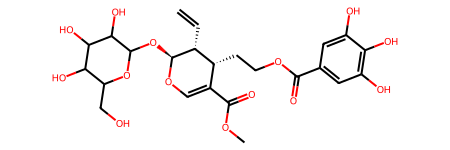

In [432]:
Chem.MolFromSmiles(all_spectrums_reference[highest_prediction_index].params['smiles'])

In [433]:
len(all_spectrums_reference_processed[highest_prediction_index].mz)

28

<Axes: xlabel='m/z', ylabel='Intensity'>

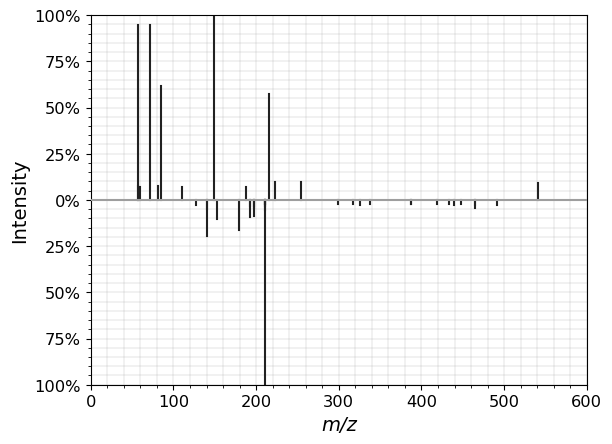

In [434]:
import spectrum_utils.plot as sup

## there is a peak disappearing after 300 for the query
#preprocess the spectrum and lets see how it looks like
import copy
target_query_copy= copy.deepcopy(target_query)
ref_copy= copy.deepcopy(all_spectrums_reference[highest_prediction_index])
pp=Preprocessor()
target_query_copy=pp.preprocess_spectrum(spectrum=target_query_copy)
ref_copy=pp.preprocess_spectrum(spectrum=ref_copy)
sup.mirror(target_query_copy, ref_copy, )

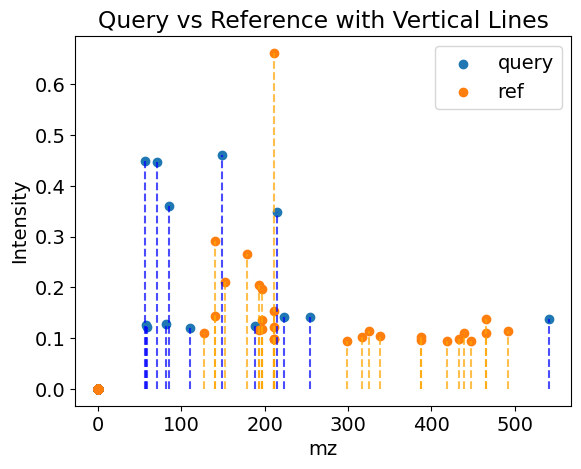

In [435]:
import matplotlib.pyplot as plt

# Example plot for the query
query_batch = dataloader_janssen.dataset[target_index]
plt.scatter(query_batch['mz'], query_batch['intensity'], label='query')

# Add vertical lines for the query
plt.vlines(query_batch['mz'], 0, query_batch['intensity'], colors='blue', linestyles='--', alpha=0.7)

# Example plot for the reference
#ref_batch = dataloader_reference.dataset[best_golden_truth_index]
#highest_prediction_index
ref_batch = dataloader_reference.dataset[highest_prediction_index]
plt.scatter(ref_batch['mz'], ref_batch['intensity'], label='ref')

# Add vertical lines for the reference
plt.vlines(ref_batch['mz'], 0, ref_batch['intensity'], colors='orange', linestyles='--', alpha=0.7)

# Add legend and show the plot
plt.legend()
plt.xlabel('mz')
plt.ylabel('Intensity')
plt.title('Query vs Reference with Vertical Lines')
plt.show()


## Highest prediction

In [436]:
print(f'Tanimoto similarity: {golden_truth[target_index, highest_prediction_index]}')

Tanimoto similarity: 0.25093283582089554


In [437]:
#print(f'The normalized MCES prediction of SIMBA for the highest truth is {similarities1[target_index, highest_prediction_index]}')

In [438]:
print(f'The MCES prediction of SIMBA for the highest truth is {40-(40*similarities1[target_index, highest_prediction_index])}')

The MCES prediction of SIMBA for the highest truth is 2.7965474128723145


In [439]:
print(f'The normalized ed prediction of SIMBA for the highest prediction is {softmax(similarities2[target_index, highest_prediction_index])}')

The normalized ed prediction of SIMBA for the highest prediction is [0.00800508 0.00321677 0.00354174 0.01116156 0.16633516 0.8077397 ]


In [440]:
print(f'intensities: {np.array(all_spectrums_reference[highest_prediction_index].intensity)/1000}')

intensities: [2.7537539e-05 4.6856861e-05 1.9397397e-04 1.0057056e-04 1.6120120e-04
 9.4954950e-05 3.0920921e-05 8.7907909e-05 4.2602598e-05 3.1841839e-05
 1.0000000e-03 2.1771770e-05 5.3133132e-05 3.3833832e-05 2.2012011e-05
 2.0440440e-05 2.3523520e-05 3.0100100e-05 2.4374369e-05 2.4074070e-05
 2.1231230e-05 2.0430431e-05 2.1671669e-05 2.7797800e-05 2.0350350e-05
 2.7517521e-05 4.3243239e-05 3.0040041e-05]


In [441]:
all_spectrums_reference[highest_prediction_index].precursor_mz

543.1708

In [442]:
similarities2_softmax[(similarities1>0.95)&(similarities2_norm<1)].shape

(5366, 6)

## Ground truth

In [443]:
print(f'Tanimoto similarity: {golden_truth[target_index, best_golden_truth_index]}')

Tanimoto similarity: 1.0


In [444]:
print(f'The normalized MCES prediction of SIMBA for the golden truth is {similarities1[target_index, best_golden_truth_index]}')

The normalized MCES prediction of SIMBA for the golden truth is 0.6889481544494629


In [445]:
print(f'The MCES prediction of SIMBA for the golden truth is {40-(40*similarities1[target_index, best_golden_truth_index])}')

The MCES prediction of SIMBA for the golden truth is 12.442073822021484


In [446]:
print(f'The normalized ed prediction of SIMBA for the golden truth is {softmax(similarities2[target_index, best_golden_truth_index])}')

The normalized ed prediction of SIMBA for the golden truth is [0.11006401 0.0363928  0.03941412 0.08106578 0.36259333 0.37046996]


In [447]:
## the best golden truth is ranked

min_ranking=np.inf
for b in best_golden_truth_list:
    ranking_found = np.where(np.argsort(similarities1[target_index])[::-1] == b)[0]
    print(ranking_found)
    min_ranking = ranking_found if ranking_found< min_ranking else min_ranking
print(f'Ranking found for specific ground truth: {min_ranking}')

[11007]
[11365]
[4544]
[4262]
[5197]
[4253]
[3875]
[4543]
[7448]
Ranking found for specific ground truth: [3875]


In [448]:
## what is the highest prediction?

In [449]:
all_spectrums_reference[highest_prediction_index].params

{'smiles': 'COC(=O)C1=CO[C@H]([C@@H]([C@@H]1CCOC(=O)C2=CC(=C(C(=C2)O)O)O)C=C)OC3C(C(C(C(O3)CO)O)O)O',
 'inchikey': 'SMTKSCGLXONVGL',
 'formula': 'C24H30O14',
 'precursor_formula': 'C24H31O14',
 'parent_mass': '542.1635239999999',
 'precursor_mz': '543.1708',
 'adduct': '[M+H]+',
 'instrument_type': 'QTOF',
 'collision_energy': '20.0',
 'fold': 'val',
 'simulation_challenge': 'True'}

In [450]:
all_spectrums_reference[highest_prediction_index].mz

array([127.0379, 141.0477, 141.056 , 153.0167, 179.0731, 193.0837,
       193.0983, 197.0767, 197.087 , 197.0954, 211.0974, 211.1486,
       211.1942, 211.2265, 211.2617, 298.9247, 316.9851, 325.1021,
       337.8788, 386.9773, 387.2672, 418.7993, 433.022 , 439.0905,
       447.8879, 465.0436, 465.2626, 491.2915])

<Axes: xlabel='m/z', ylabel='Intensity'>

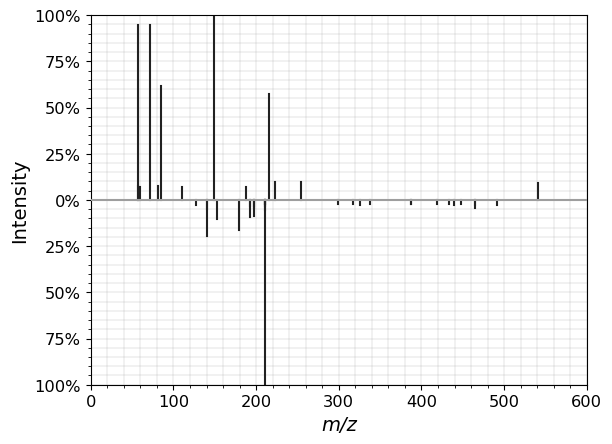

In [451]:
import spectrum_utils.plot as sup
sup.mirror(target_query, all_spectrums_reference[highest_prediction_index], )

In [452]:
golden_truth[target_index, highest_prediction_index]

0.25093283582089554

In [453]:
print(f'The normalized ed prediction of SIMBA for the highest mces  is {softmax(similarities2[target_index, highest_prediction_index])}')

The normalized ed prediction of SIMBA for the highest mces  is [0.00800508 0.00321677 0.00354174 0.01116156 0.16633516 0.8077397 ]


In [454]:
len(all_spectrums_reference[highest_prediction_index].mz)

28

<Axes: xlabel='m/z', ylabel='Intensity'>

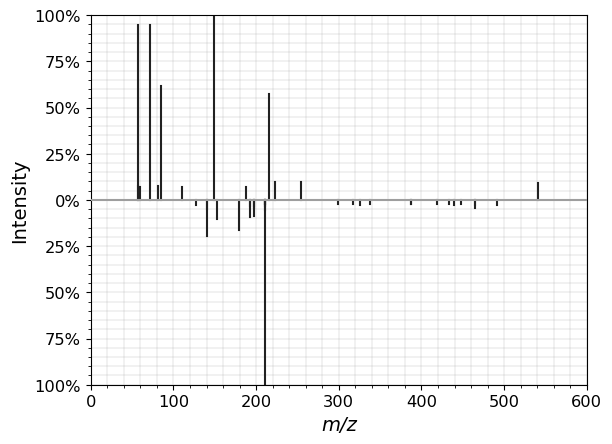

In [455]:
sup.mirror(target_query, all_spectrums_reference[highest_prediction_index], )

In [456]:
more_informative_spectrums[highest_prediction_index]

1

In [457]:
best_golden_truth_list

array([299794, 299795, 299796, 299797, 310759, 310760, 310761, 310762,
       310763])

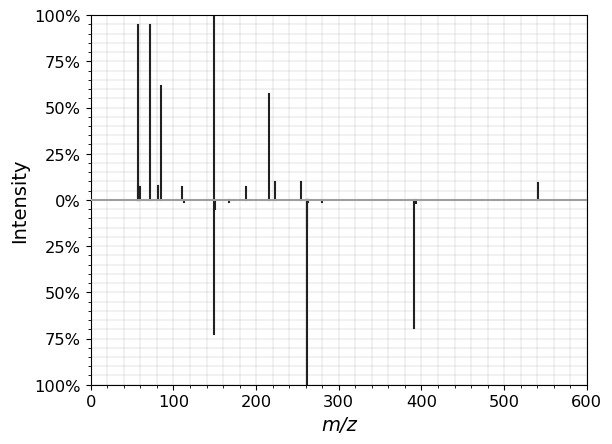

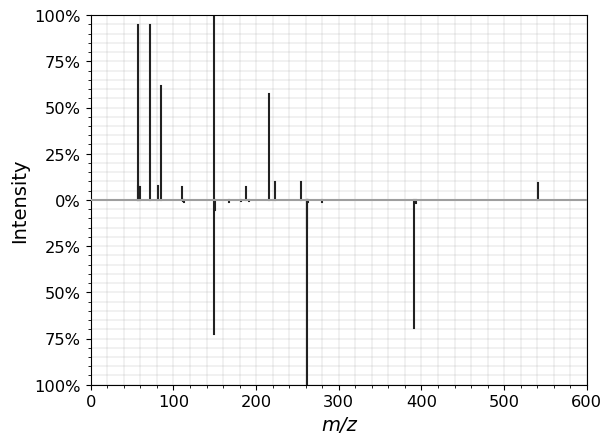

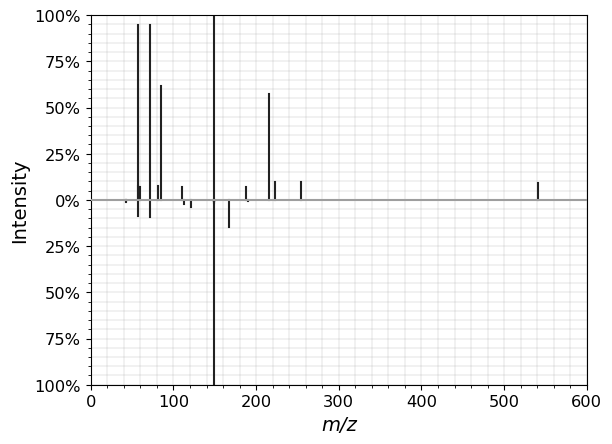

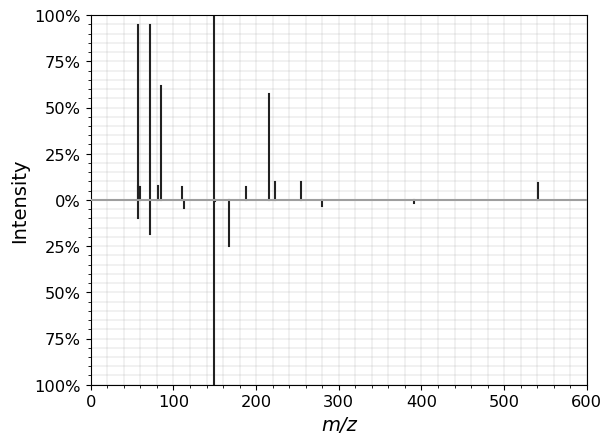

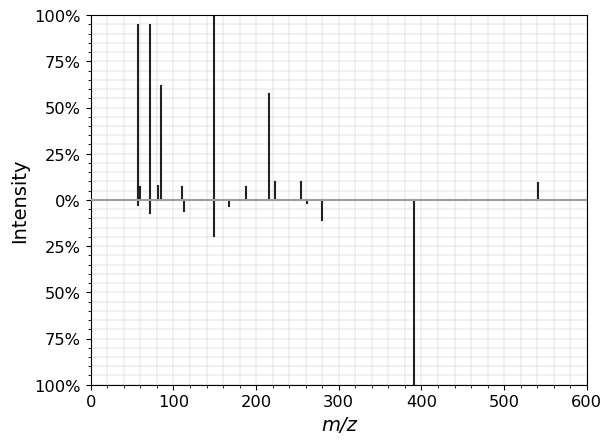

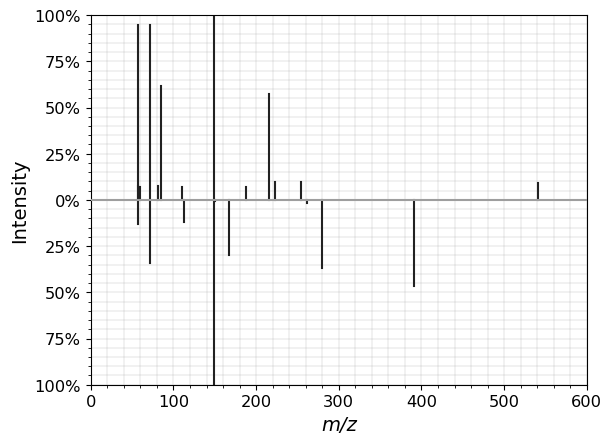

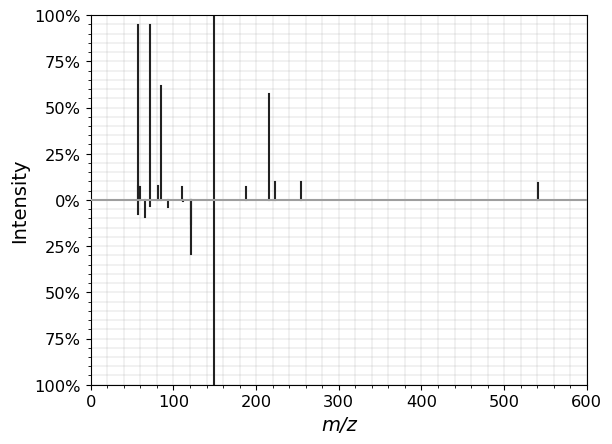

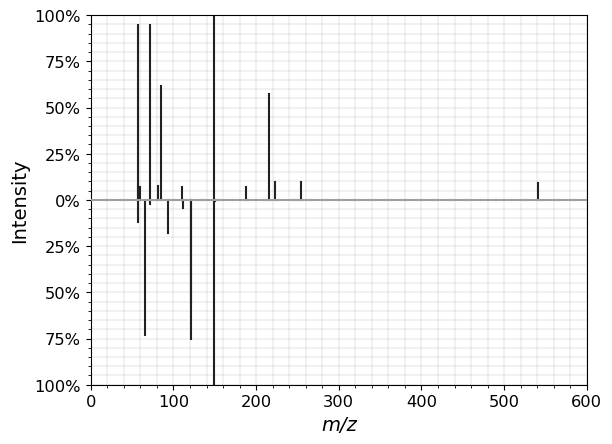

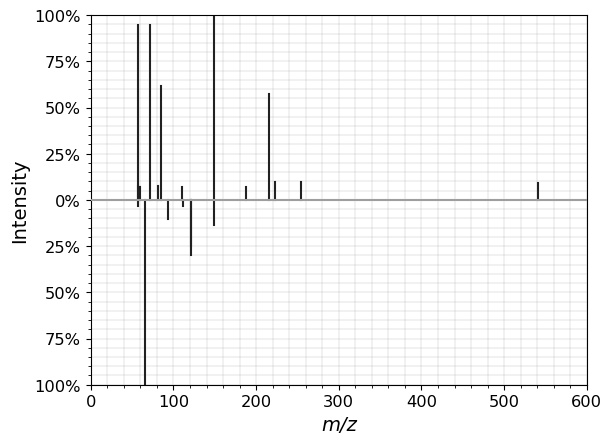

In [458]:
for b in best_golden_truth_list:
    plt.figure()
    sup.mirror(target_query, all_spectrums_reference[b], )

## There are spectrums that have generate more high similarity predictions?

In [459]:
similarities1.shape

(132, 328555)

In [460]:
#number_similar_spectra=np.sum(golden_truth>0.9, axis=0)
number_similar_spectra=np.sum(similarities1>0.95, axis=0)
number_similar_spectra = number_similar_spectra>=5

In [461]:
np.sum(similarities1>0.9)/(similarities1.shape[0]*similarities1.shape[1])

0.005602539679026112

In [462]:
similarities1.shape[0]*similarities1.shape[1]

43369260

In [463]:
number_similar_spectra

array([False, False, False, ..., False, False, False])

In [464]:
spectrums_puta= [all_spectrums_reference_processed[i] for i in range(0, len(all_spectrums_reference_processed)) if number_similar_spectra[i]]
len_z_puta = [len(s.mz) for s in spectrums_puta]
len_z_ref = [len(s.mz) for s in all_spectrums_reference_processed]

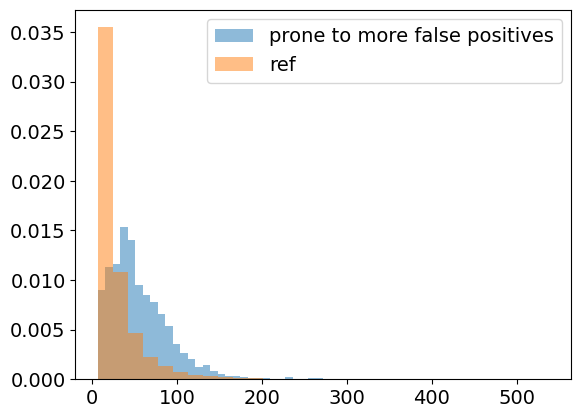

In [465]:
_=plt.hist(len_z_puta, bins=30, label='prone to more false positives', alpha=0.5, density=True)
_=plt.hist(len_z_ref, bins=30, label='ref',alpha=0.5,density=True)
plt.legend()

In [466]:
## plot random similarity 1
similarities1_high= np.where(similarities1>0.98)
similarities1_high

(array([  0,   0,   0, ..., 131, 131, 131]),
 array([ 42461,  42462,  42463, ..., 113185, 113700, 113701]))

index janssen: 43
Number of peaks s1: 36, Number of peaks s2: 25


<Axes: xlabel='m/z', ylabel='Intensity'>

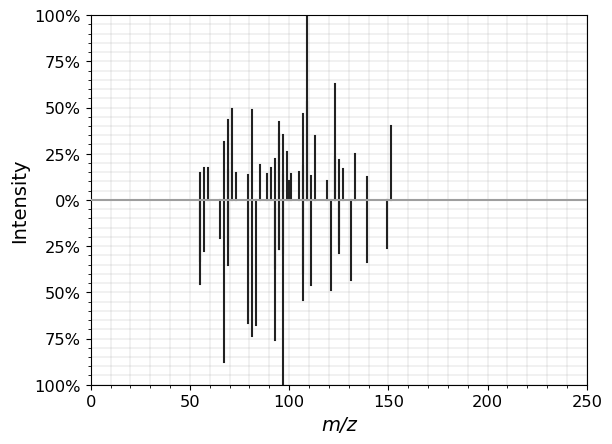

In [467]:
index_random=np.random.randint(0,len(similarities1_high[0]))


s1 = all_spectrums_janssen[similarities1_high[0][index_random]]
s1_copy= copy.deepcopy(s1)
s1_copy = pp.preprocess_spectrum(
            s1_copy,
            fragment_tol_mass=10,
            fragment_tol_mode="ppm",
            min_intensity=0.01,
            max_num_peaks=40,
            scale_intensity='root',
        )

print(f'index janssen: {similarities1_high[0][index_random]}')
s2 = all_spectrums_reference_processed[similarities1_high[1][index_random]]
print(f'Number of peaks s1: {len(s1_copy.mz)}, Number of peaks s2: {len(s2.mz)}')
sup.mirror(s1_copy, s2, )

In [468]:
index=np.argsort(len_z)[-8]
s=spectrums_puta[index]
spectrum_puta_processed = copy.deepcopy(s)

print(f'Before first filter: {len(spectrum_puta_processed.mz)}')
spectrum_puta_processed= spectrum_puta_processed.remove_precursor_peak(10, "ppm")\
            .filter_intensity(min_intensity=0.01, max_num_peaks=100000) \
            

print(f'After first filter: {len(spectrum_puta_processed.mz)}')

spectrum_puta_processed= spectrum_puta_processed.filter_intensity(min_intensity=0.01, max_num_peaks=40)

print(f'After second filter: {len(spectrum_puta_processed.mz)}')

sup.mirror(s, spectrum_puta_processed, )

NameError: name 'len_z' is not defined

In [ ]:
len(spectrum_puta_processed.mz)

In [ ]:
index_with_more_peaks=np.argmax(len_z)
index_with_more_peaks

In [ ]:
ref_batch = dataloader_reference.dataset[index_with_more_peaks]
plt.scatter(ref_batch['mz'], ref_batch['intensity'], label='ref')

# Add vertical lines for the reference
plt.vlines(ref_batch['mz'], 0, ref_batch['intensity'], colors='orange', linestyles='--', alpha=0.7)

# Add legend and show the plot
plt.legend()
plt.xlabel('mz')
plt.ylabel('Intensity')
plt.title('Query vs Reference with Vertical Lines')
plt.show()


In [ ]:
golden_truth

In [ ]:
random.seed(42)

In [ ]:
random.seed(42)

In [ ]:
random.random()

In [ ]:
array = np.array([[3,4,2],[6,5,1]])

In [ ]:
np.sort(array, axis=1)

In [ ]:
np.argsort(array, axis=1)[:,::-1]

In [ ]:
indexes=np.argsort(array, axis=1)
indexes